In [37]:
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
train_df = pd.read_csv('lgb_train.tsv',sep='\t')
test_df = pd.read_csv('lgb_test.tsv',sep='\t')

id_vars = ['guid/image']
label_vars = ['gt_label']
gt_vars = []
cocov1_vars = []
kitti_vars = []
incep_vars = []
for col in train_df.columns:
    if col.startswith('gt') and col != 'gt_label':
        gt_vars.append(col)
    elif col.startswith('cocov1'):
        cocov1_vars.append(col)
    elif col.startswith('kitti'):
        kitti_vars.append(col)
    elif col.startswith('incep'):
        incep_vars.append(col)
    
print len(gt_vars)+len(cocov1_vars)+len(kitti_vars)+len(incep_vars)+len(id_vars)+len(label_vars) ==len(train_df.columns)

train_X = train_df[cocov1_vars + kitti_vars + incep_vars]
train_y = train_df[label_vars]
test_X = test_df[cocov1_vars + kitti_vars + incep_vars]

True


In [35]:
# Splitting the data for model training#
shuffle_idx = np.arange(len(train_X))
np.random.seed(2018)
np.random.shuffle(shuffle_idx)
split = int(0.8*len(shuffle_idx))
dev_X = train_X.iloc[shuffle_idx[:split],:]
val_X = train_X.iloc[shuffle_idx[split:],:]
dev_y = train_y.iloc[shuffle_idx[:split],:]
val_y = train_y.iloc[shuffle_idx[split:],:]
print(dev_X.shape, val_X.shape, test_X.shape)

((6058, 30), (1515, 30), (2631, 30))


In [36]:
dev_X.head()

,cocov1-can1-label,cocov1-can1-score,cocov1-can1-ymin,cocov1-can1-xmin,cocov1-can1-ymax,cocov1-can1-xmax,cocov1-can1-box-width,cocov1-can1-box-height,cocov1-can1-box-ratio,cocov1-can1-box-area,...,incep-can1-label,incep-can1-score,incep-can1-ymin,incep-can1-xmin,incep-can1-ymax,incep-can1-xmax,incep-can1-box-width,incep-can1-box-height,incep-can1-box-ratio,incep-can1-box-area
5726,2,0.999820,0.000000,0.000000,985.140326,569.375555,569.375555,985.140326,1.730212,560914.819315,...,2,0.999988,2.847549,4.005978,973.143090,536.115427,532.109449,970.295541,1.823489,516303.426171
6931,1,0.991420,444.221048,0.000000,560.755119,67.163571,67.163571,116.534071,1.735079,7826.844328,...,1,0.999988,447.097097,1.281633,561.344977,72.518619,71.236986,114.247880,1.603772,8138.674625
16,1,0.999823,409.773367,1123.098311,443.245373,1187.612412,64.514101,33.472006,0.518832,2159.416335,...,1,0.999996,407.646006,1138.056114,439.936572,1190.475788,52.419675,32.290567,0.616001,1692.660993
3516,1,0.999376,385.345674,912.463994,429.936870,985.110351,72.646357,44.591196,0.613812,3239.387920,...,1,0.999849,394.100230,905.887663,429.250260,984.619108,78.731445,35.150030,0.446455,2767.412640
5040,1,0.999587,400.023007,937.893502,461.179745,1008.920218,71.026716,61.156738,0.861039,4343.762248,...,1,0.999995,407.601580,950.829748,461.936709,1016.016427,65.186679,54.335129,0.833531,3541.926568


In [38]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):

    lgtrain = lgb.Dataset(train_X, label=train_y, categorical_feature=['cocov1-can1-label','kitti-can1-label'])
    lgval = lgb.Dataset(val_X, label=val_y, reference=lgtrain, categorical_feature=['cocov1-can1-label','kitti-can1-label'])

    evals_result = {}
    params = {
        'objective' : 'multiclass',
        'num_class' : 3,
        'learning_rate' : 0.1,
        'bagging_seed' : 2018,
    }
    model = lgb.train(params, 
                      lgtrain, 
                      num_boost_round=1000, 
                      valid_sets=[lgval], 
                      categorical_feature=['cocov1-can1-label','kitti-can1-label'],
                      early_stopping_rounds=100,
                      evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result
    
    
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    

[1]	valid_0's multi_logloss: 0.956177
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 0.838254
[3]	valid_0's multi_logloss: 0.738915
[4]	valid_0's multi_logloss: 0.654276
[5]	valid_0's multi_logloss: 0.581364
[6]	valid_0's multi_logloss: 0.518227
[7]	valid_0's multi_logloss: 0.463006
[8]	valid_0's multi_logloss: 0.414779
[9]	valid_0's multi_logloss: 0.37224
[10]	valid_0's multi_logloss: 0.334672
[11]	valid_0's multi_logloss: 0.301412
[12]	valid_0's multi_logloss: 0.271857
[13]	valid_0's multi_logloss: 0.24554
[14]	valid_0's multi_logloss: 0.222011
[15]	valid_0's multi_logloss: 0.201041
[16]	valid_0's multi_logloss: 0.182282
[17]	valid_0's multi_logloss: 0.16539
[18]	valid_0's multi_logloss: 0.150322
[19]	valid_0's multi_logloss: 0.136756
[20]	valid_0's multi_logloss: 0.124658
[21]	valid_0's multi_logloss: 0.113721
[22]	valid_0's multi_logloss: 0.103899
[23]	valid_0's multi_logloss: 0.0951266
[24]	valid_0's multi_logloss: 0.0871255
[25]	valid_

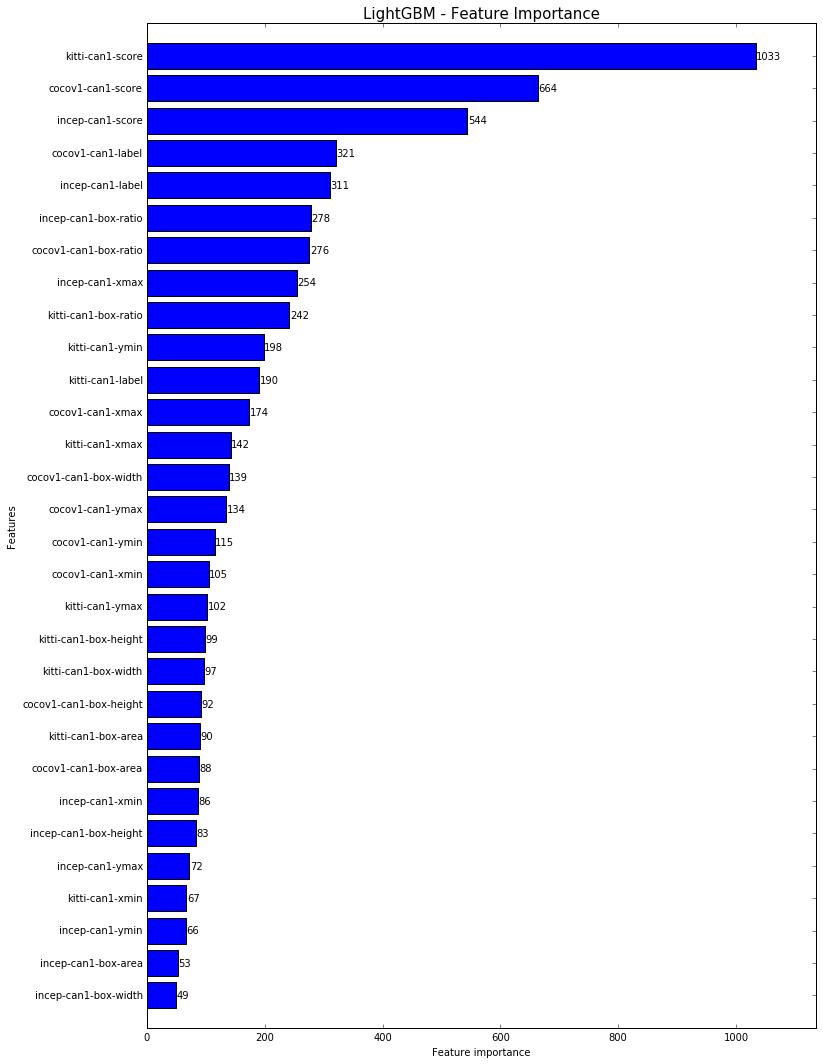

In [39]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [40]:
test_X.head()

,cocov1-can1-label,cocov1-can1-score,cocov1-can1-ymin,cocov1-can1-xmin,cocov1-can1-ymax,cocov1-can1-xmax,cocov1-can1-box-width,cocov1-can1-box-height,cocov1-can1-box-ratio,cocov1-can1-box-area,...,incep-can1-label,incep-can1-score,incep-can1-ymin,incep-can1-xmin,incep-can1-ymax,incep-can1-xmax,incep-can1-box-width,incep-can1-box-height,incep-can1-box-ratio,incep-can1-box-area
0,0,1.0,105.870206,778.004116,599.913759,1198.261631,420.257514,494.043552,1.175573,207625.515156,...,0,0.999922,114.727974,778.541677,597.486985,1199.429844,420.888167,482.759011,1.147001,203187.555194
1,0,1.0,107.833644,768.235507,598.237929,1182.570957,414.335451,490.404285,1.183592,203191.880580,...,0,0.999919,118.921772,768.581806,588.000484,1186.015816,417.434010,469.078712,1.123719,195809.407618
2,0,1.0,99.043518,796.189221,601.950952,1224.586350,428.397129,502.907433,1.173928,215444.100425,...,0,0.999927,108.871812,798.997039,594.052243,1221.967910,422.970871,485.180431,1.147078,205217.189787
3,0,1.0,98.499827,792.350204,604.166475,1221.011094,428.660889,505.666648,1.179643,216759.515104,...,0,0.999941,112.773276,792.317748,592.349200,1215.951043,423.633296,479.575925,1.132054,203164.329518
4,0,1.0,99.756652,789.944644,605.358793,1219.450434,429.505790,505.602141,1.177172,217159.047226,...,0,0.999928,111.382233,791.457046,593.168555,1211.594545,420.137499,481.786322,1.146735,202416.500180


In [41]:
test_df['lgb_pred'] = np.argmax(pred_test,axis=1)
compare_df = test_df[['lgb_pred','cocov1-can1-label','kitti-can1-label']]

In [44]:
compare_df[compare_df['lgb_pred'] != compare_df['cocov1-can1-label']].shape

(308, 3)

In [45]:
sub = test_df[['guid/image','lgb_pred']]
sub.head()

,guid/image,lgb_pred
0,0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0000,0
1,0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0001,0
2,0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0002,0
3,0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0003,0
4,0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0004,0


In [46]:
sub.columns = ['guid/image','label']
sub.to_csv('sub14.csv',index=False)